# Capastone Project - The Battle of Neighborhoods

### Business Problem

Our client is interested in opening a new University in Venezuela in the state of Miranda. We will be analyzing data from neighboorhoods, population, and education venues using Foursquare API in order to figure where in the state would a new campus be most needed. This will increase our clients chances of getting a licence from the department of education as well as increase their bottom line. 

First we will import the libraries we are going to use:

In [1]:
import numpy as np
import pandas as pd
!pip install folium
import folium
from geopy.geocoders import Nominatim
from tqdm import tqdm
import requests
from collections import deque
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt

%matplotlib inline

     |████████████████████████████████| 102kB 10.3MB/s ta 0:00:01


#### Data acquisition

Because data was not available in a single source. Data from different sources was collected. This data includes the boroughs and neighboorhoods of the state of Miranda, Venezuela, population, as well as longitudes and latitudes that were found on geohack through wikipedia. This was combined in a table and saved as a csv file in order to use it in this notebook for further analysis

In [2]:

# @hidden_cell
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.
credentials_1 = {
    'IAM_SERVICE_ID': 'iam-ServiceId-c7baf243-5f3c-4a67-9323-10aaa6e7bd11',
    'IBM_API_KEY_ID': 'IVi73CFjezHvV7qMOc-8jqY85RzJAi17MBYlvlOgfo6Z',
    'ENDPOINT': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'IBM_AUTH_ENDPOINT': 'https://iam.cloud.ibm.com/oidc/token',
    'BUCKET': 'capstoneprojectthebattleofneighbo-donotdelete-pr-mc9sdymgr2jhit',
    'FILE': 'DataMiranda.csv'
}


In [3]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_d02431fcc2f0433d9300f82440148acf = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='IVi73CFjezHvV7qMOc-8jqY85RzJAi17MBYlvlOgfo6Z',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_d02431fcc2f0433d9300f82440148acf.get_object(Bucket='capstoneprojectthebattleofneighbo-donotdelete-pr-mc9sdymgr2jhit',Key='DataMiranda.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

Miranda_data = pd.read_csv(body)
Miranda_data.head()


,Municipio,Parroquia,Population,Latitude,Longitude
0,Acevedo,Caucagua,27948,10.282222,-66.377222
1,Acevedo,Araguita,6043,9.914444,-65.193611
2,Acevedo,Arevalo Gonzalez,6509,9.914444,-65.193611
3,Acevedo,Capaya,13151,10.428600,-66.271700
4,Acevedo,El Cafe,6477,10.428600,-66.271700


In [4]:
Miranda_data.shape

(55, 5)

In [5]:
address = 'Miranda, Venezuela'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Miranda are {}, {}.'.format(latitude, longitude))

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  app.launch_new_instance()


The geograpical coordinate of Miranda are 10.25, -66.416667.


In [6]:
# create map of New York using latitude and longitude values
map_Miranda = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(Miranda_data['Latitude'], Miranda_data['Longitude'], Miranda_data['Municipio'], Miranda_data['Parroquia']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Miranda)  
    
map_Miranda

In [7]:
LIMIT = 500 
radius = 5000 

CLIENT_ID = 'FJYN3BOLAJMLC2YLHMU4Y5QR2FTTQKFSU5IUGVGOFTYKYPTS' # your Foursquare ID
CLIENT_SECRET = 'AWXKLX0Z3DQK5ZGFVFDGU0G4JVN52PXFE2MQSWBQMH2IJXMY' # your Foursquare Secret
VERSION = '20200521' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: FJYN3BOLAJMLC2YLHMU4Y5QR2FTTQKFSU5IUGVGOFTYKYPTS
CLIENT_SECRET:AWXKLX0Z3DQK5ZGFVFDGU0G4JVN52PXFE2MQSWBQMH2IJXMY


In [8]:
import urllib
def getNearbyVenues(names, latitudes, longitudes, radius=5000, categoryIds=''):
    try:
        venues_list=[]
        for name, lat, lng in zip(names, latitudes, longitudes):
            #print(name)

            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)

            if (categoryIds != ''):
                url = url + '&categoryId={}'
                url = url.format(categoryIds)

            # make the GET request
            response = requests.get(url).json()
            results = response["response"]['venues']

            # return only relevant information for each nearby venue
            for v in results:
                success = False
                try:
                    category = v['categories'][0]['name']
                    success = True
                except:
                    pass

                if success:
                    venues_list.append([(
                        name, 
                        lat, 
                        lng, 
                        v['name'], 
                        v['location']['lat'], 
                        v['location']['lng'],
                        v['categories'][0]['name']
                    )])

        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',  
                  'Venue Category']
    
    except:
        print(url)
        print(response)
        print(results)
        print(nearby_venues)

    return(nearby_venues)

In [9]:
#https://developer.foursquare.com/docs/resources/categories
#College and University = 4d4b7105d754a06372d81259
Miranda_venues_university = getNearbyVenues(names=Miranda_data['Parroquia'], latitudes=Miranda_data['Latitude'], longitudes=Miranda_data['Longitude'], radius=5000, categoryIds='4d4b7105d754a06372d81259')
Miranda_venues_university.head()


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Araguita,9.914444,-65.193611,"Casa de la Cultura ""Manuel Moreno Hernandez""",9.951736,-65.164397,Community College
1,Arevalo Gonzalez,9.914444,-65.193611,"Casa de la Cultura ""Manuel Moreno Hernandez""",9.951736,-65.164397,Community College
2,Baruta,10.420000,-66.870000,"Laboratorio E, sección de Metalurgia Extractiva",10.429760,-66.874582,College Lab
3,Baruta,10.420000,-66.870000,Campo de Fútbol USB,10.412605,-66.888371,College Soccer Field
4,Baruta,10.420000,-66.870000,Universidad Nacional Experimental Politécnica ...,10.392525,-66.890137,University


In [10]:
Miranda_venues_university.shape

(943, 7)

In [11]:
Miranda_venues_university['Neighborhood'].values

array(['Araguita', 'Arevalo Gonzalez', 'Baruta', 'Baruta', 'Baruta',
       'Baruta', 'Baruta', 'Baruta', 'Baruta', 'Baruta', 'Baruta',
       'Baruta', 'Baruta', 'Baruta', 'Baruta', 'Baruta', 'Baruta',
       'Baruta', 'Baruta', 'Baruta', 'Baruta', 'Baruta', 'Baruta',
       'Baruta', 'Baruta', 'Baruta', 'Baruta', 'Baruta', 'Baruta',
       'Baruta', 'Baruta', 'Baruta', 'Baruta', 'Baruta', 'Baruta',
       'Baruta', 'Baruta', 'Baruta', 'Baruta', 'Baruta', 'Baruta',
       'Baruta', 'Baruta', 'Baruta', 'Baruta', 'Baruta', 'Baruta',
       'Baruta', 'Baruta', 'Baruta', 'El Cafetal', 'El Cafetal',
       'El Cafetal', 'El Cafetal', 'El Cafetal', 'El Cafetal',
       'El Cafetal', 'El Cafetal', 'El Cafetal', 'El Cafetal',
       'El Cafetal', 'El Cafetal', 'El Cafetal', 'El Cafetal',
       'El Cafetal', 'El Cafetal', 'El Cafetal', 'El Cafetal',
       'El Cafetal', 'El Cafetal', 'El Cafetal', 'El Cafetal',
       'El Cafetal', 'El Cafetal', 'El Cafetal', 'El Cafetal',
       'El Cafetal'

In [12]:
def addToMap(df, color, existingMap):
    for lat, lng, local, venue, venueCat in zip(df['Venue Latitude'], df['Venue Longitude'], df['Neighborhood'], df['Venue'], df['Venue Category']):
        label = '{} ({}) - {}'.format(venue, venueCat, local)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7).add_to(existingMap)

In [13]:
map_Miranda_university = folium.Map(location=[latitude, longitude], zoom_start=10)
addToMap(Miranda_venues_university, 'red', map_Miranda_university)

map_Miranda_university


In [14]:
Miranda_venues_university_grouped = Miranda_venues_university.groupby('Neighborhood').count()
Miranda_venues_university_grouped

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Altagracia de la Montana,36,36,36,36,36,36
Araguita,1,1,1,1,1,1
Arevalo Gonzalez,1,1,1,1,1,1
Baruta,48,48,48,48,48,48
Bolivar,24,24,24,24,24,24
Carrizal,47,47,47,47,47,47
Caucaguita,48,48,48,48,48,48
Cecilio Acosta,36,36,36,36,36,36
Chacao,48,48,48,48,48,48


In [15]:
# One hot encoding
Miranda_onehot = pd.get_dummies(Miranda_venues_university[['Venue Category']], prefix="", prefix_sep ="")

#add neighborhoods back to the dataframe
Miranda_onehot['Neighborhood'] = Miranda_venues_university['Neighborhood']

#Move neighborhoods column to the first column
fixed_columns = [Miranda_onehot.columns[-1]] + list(Miranda_onehot.columns[:-1])
Miranda_onehot = Miranda_onehot[fixed_columns]

Miranda_onehot.head()

,Neighborhood,College & University,College Academic Building,College Administrative Building,College Arts Building,College Auditorium,College Bookstore,College Cafeteria,College Classroom,College Communications Building,...,General College & University,Gym,High School,Language School,Law School,Medical School,School,Student Center,Trade School,University
0,Araguita,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Arevalo Gonzalez,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Baruta,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Baruta,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Baruta,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [16]:
Miranda_grouped = Miranda_onehot.groupby('Neighborhood').mean().reset_index()
Miranda_grouped

,Neighborhood,College & University,College Academic Building,College Administrative Building,College Arts Building,College Auditorium,College Bookstore,College Cafeteria,College Classroom,College Communications Building,...,General College & University,Gym,High School,Language School,Law School,Medical School,School,Student Center,Trade School,University
0,Altagracia de la Montana,0.000000,0.166667,0.027778,0.000000,0.027778,0.000000,0.027778,0.055556,0.000000,...,0.027778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.027778,0.194444
1,Araguita,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Arevalo Gonzalez,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Baruta,0.000000,0.062500,0.083333,0.020833,0.041667,0.041667,0.020833,0.062500,0.000000,...,0.020833,0.000000,0.020833,0.020833,0.000000,0.020833,0.000000,0.000000,0.020833,0.020833
4,Bolivar,0.000000,0.166667,0.000000,0.000000,0.041667,0.000000,0.000000,0.041667,0.000000,...,0.083333,0.000000,0.000000,0.000000,0.000000,0.041667,0.083333,0.250000,0.041667,0.083333
5,Carrizal,0.000000,0.106383,0.021277,0.000000,0.021277,0.021277,0.042553,0.063830,0.021277,...,0.021277,0.021277,0.000000,0.000000,0.000000,0.000000,0.000000,0.063830,0.021277,0.170213
6,Caucaguita,0.020833,0.083333,0.020833,0.000000,0.083333,0.000000,0.000000,0.145833,0.000000,...,0.041667,0.000000,0.020833,0.020833,0.020833,0.000000,0.000000,0.041667,0.104167,0.104167
7,Cecilio Acosta,0.000000,0.166667,0.027778,0.000000,0.027778,0.000000,0.027778,0.055556,0.000000,...,0.027778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.027778,0.194444
8,Chacao,0.020833,0.062500,0.062500,0.000000,0.083333,0.000000,0.000000,0.145833,0.000000,...,0.041667,0.000000,0.000000,0.020833,0.020833,0.000000,0.000000,0.041667,0.104167,0.125000
9,Charallave,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000


In [17]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [18]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Miranda_venues_sorted = pd.DataFrame(columns=columns)
Miranda_venues_sorted['Neighborhood'] = Miranda_grouped['Neighborhood']

for ind in np.arange(Miranda_grouped.shape[0]):
    Miranda_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Miranda_grouped.iloc[ind, :], num_top_venues)

Miranda_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Altagracia de la Montana,Community College,University,College Academic Building,Student Center,College Classroom,College Library,College Auditorium,College Cafeteria,College Administrative Building,College Engineering Building
1,Araguita,Community College,University,College Communications Building,College Quad,College Library,College Lab,College Gym,College Engineering Building,College Classroom,College Residence Hall
2,Arevalo Gonzalez,Community College,University,College Communications Building,College Quad,College Library,College Lab,College Gym,College Engineering Building,College Classroom,College Residence Hall
3,Baruta,College Lab,College Engineering Building,College Administrative Building,College Academic Building,College Classroom,College Auditorium,Fraternity House,College Bookstore,High School,General College & University
4,Bolivar,Student Center,College Academic Building,Community College,University,School,General College & University,College Classroom,Medical School,College Auditorium,Trade School


## Neighborhood Clustering

In [19]:
# set number of clusters
kclusters = 5

Miranda_grouped_clustering = Miranda_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Miranda_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 2, 2, 1, 1, 1, 1, 1, 1, 4], dtype=int32)

In [20]:
# add clustering labels
Miranda_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Miranda_merged = Miranda_data
Miranda_merged = Miranda_merged.join(Miranda_venues_sorted.set_index('Neighborhood'), on='Parroquia')

Miranda_merged = Miranda_merged.dropna()
Miranda_merged['Cluster Labels'] = Miranda_merged['Cluster Labels'].astype(int)
Miranda_merged

,Municipio,Parroquia,Population,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Acevedo,Araguita,6043,9.914444,-65.193611,2,Community College,University,College Communications Building,College Quad,College Library,College Lab,College Gym,College Engineering Building,College Classroom,College Residence Hall
2,Acevedo,Arevalo Gonzalez,6509,9.914444,-65.193611,2,Community College,University,College Communications Building,College Quad,College Library,College Lab,College Gym,College Engineering Building,College Classroom,College Residence Hall
10,Baruta,Baruta,159142,10.420000,-66.870000,1,College Lab,College Engineering Building,College Administrative Building,College Academic Building,College Classroom,College Auditorium,Fraternity House,College Bookstore,High School,General College & University
11,Baruta,El Cafetal,41543,10.466667,-66.833333,1,Community College,College Classroom,University,Trade School,College Auditorium,College Administrative Building,College Gym,Student Center,College Academic Building,Language School
12,Baruta,Las Minas de Baruta,40070,10.446944,-66.862500,1,College Classroom,College Administrative Building,Community College,College Engineering Building,Trade School,University,Language School,General College & University,College Cafeteria,College Academic Building
17,Carrizal,Carrizal,51712,10.347091,-66.992912,1,University,Community College,College Library,College Lab,College Academic Building,Student Center,College Classroom,College Cafeteria,College Administrative Building,College Auditorium
18,Chacao,Chacao,61213,10.483333,-66.833333,1,College Classroom,Community College,University,Trade School,College Auditorium,College Academic Building,College Administrative Building,College Gym,Student Center,College Library
19,Cristobal Rojas,Charallave,91701,10.243056,-66.862222,4,University,College Classroom,College Residence Hall,College Academic Building,College Administrative Building,College Arts Building,College Auditorium,College Bookstore,College Cafeteria,College Communications Building
20,Cristobal Rojas,Las Brisas,26187,10.243056,-66.862222,4,University,College Classroom,College Residence Hall,College Academic Building,College Administrative Building,College Arts Building,College Auditorium,College Bookstore,College Cafeteria,College Communications Building
21,El Hatillo,El Hatillo,58156,10.439167,-66.830000,1,College Classroom,Community College,Trade School,College Auditorium,General College & University,College Technology Building,Student Center,College Academic Building,College Gym,College Lab


In [21]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Miranda_merged['Latitude'], Miranda_merged['Longitude'], Miranda_merged['Parroquia'], Miranda_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [22]:
Miranda_merged.loc[Miranda_merged['Cluster Labels'] == 0, Miranda_merged.columns[[1] + list(range(5, Miranda_merged.shape[1]))]]

,Parroquia,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
35,Rio Chico,0,University,College Bookstore,College Cafeteria,College Engineering Building,College Residence Hall,College Academic Building,College Administrative Building,College Arts Building,College Auditorium,College Classroom
36,El Guapo,0,University,College Bookstore,College Cafeteria,College Engineering Building,College Residence Hall,College Academic Building,College Administrative Building,College Arts Building,College Auditorium,College Classroom
37,Tacarigua de la Laguna,0,University,College Bookstore,College Cafeteria,College Engineering Building,College Residence Hall,College Academic Building,College Administrative Building,College Arts Building,College Auditorium,College Classroom
38,Paparo,0,University,College Bookstore,College Cafeteria,College Engineering Building,College Residence Hall,College Academic Building,College Administrative Building,College Arts Building,College Auditorium,College Classroom
39,San Fernando del Guapo,0,University,College Bookstore,College Cafeteria,College Engineering Building,College Residence Hall,College Academic Building,College Administrative Building,College Arts Building,College Auditorium,College Classroom


In [23]:
Miranda_merged.loc[Miranda_merged['Cluster Labels'] == 1, Miranda_merged.columns[[1] + list(range(5, Miranda_merged.shape[1]))]]

,Parroquia,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Baruta,1,College Lab,College Engineering Building,College Administrative Building,College Academic Building,College Classroom,College Auditorium,Fraternity House,College Bookstore,High School,General College & University
11,El Cafetal,1,Community College,College Classroom,University,Trade School,College Auditorium,College Administrative Building,College Gym,Student Center,College Academic Building,Language School
12,Las Minas de Baruta,1,College Classroom,College Administrative Building,Community College,College Engineering Building,Trade School,University,Language School,General College & University,College Cafeteria,College Academic Building
17,Carrizal,1,University,Community College,College Library,College Lab,College Academic Building,Student Center,College Classroom,College Cafeteria,College Administrative Building,College Auditorium
18,Chacao,1,College Classroom,Community College,University,Trade School,College Auditorium,College Academic Building,College Administrative Building,College Gym,Student Center,College Library
21,El Hatillo,1,College Classroom,Community College,Trade School,College Auditorium,General College & University,College Technology Building,Student Center,College Academic Building,College Gym,College Lab
22,Los Teques,1,Community College,University,College Academic Building,Student Center,College Classroom,College Library,College Auditorium,College Cafeteria,College Administrative Building,College Engineering Building
23,Altagracia de la Montana,1,Community College,University,College Academic Building,Student Center,College Classroom,College Library,College Auditorium,College Cafeteria,College Administrative Building,College Engineering Building
24,Cecilio Acosta,1,Community College,University,College Academic Building,Student Center,College Classroom,College Library,College Auditorium,College Cafeteria,College Administrative Building,College Engineering Building
25,El Jarillo,1,Community College,University,College Academic Building,Student Center,College Classroom,College Library,College Auditorium,College Cafeteria,College Administrative Building,College Engineering Building


In [24]:
Miranda_merged.loc[Miranda_merged['Cluster Labels'] == 2, Miranda_merged.columns[[1] + list(range(5, Miranda_merged.shape[1]))]]

,Parroquia,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Araguita,2,Community College,University,College Communications Building,College Quad,College Library,College Lab,College Gym,College Engineering Building,College Classroom,College Residence Hall
2,Arevalo Gonzalez,2,Community College,University,College Communications Building,College Quad,College Library,College Lab,College Gym,College Engineering Building,College Classroom,College Residence Hall
40,Santa Lucía,2,Community College,University,College Communications Building,College Quad,College Library,College Lab,College Gym,College Engineering Building,College Classroom,College Residence Hall


In [25]:
Miranda_merged.loc[Miranda_merged['Cluster Labels'] == 3, Miranda_merged.columns[[1] + list(range(5, Miranda_merged.shape[1]))]]

,Parroquia,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
44,San Francisco de Yare,3,Trade School,College Communications Building,College Rec Center,College Quad,College Library,College Lab,College Gym,College Engineering Building,University,College Residence Hall
45,San Antonio de Yare,3,Trade School,College Communications Building,College Rec Center,College Quad,College Library,College Lab,College Gym,College Engineering Building,University,College Residence Hall


In [26]:
Miranda_merged.loc[Miranda_merged['Cluster Labels'] == 4, Miranda_merged.columns[[1] + list(range(5, Miranda_merged.shape[1]))]]

,Parroquia,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Charallave,4,University,College Classroom,College Residence Hall,College Academic Building,College Administrative Building,College Arts Building,College Auditorium,College Bookstore,College Cafeteria,College Communications Building
20,Las Brisas,4,University,College Classroom,College Residence Hall,College Academic Building,College Administrative Building,College Arts Building,College Auditorium,College Bookstore,College Cafeteria,College Communications Building


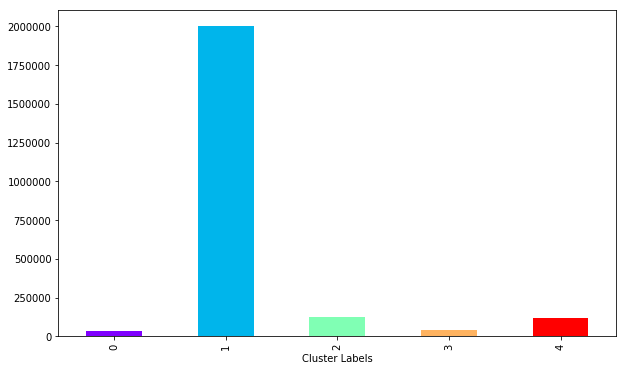

In [27]:
PpC = Miranda_merged.groupby("Cluster Labels").Population.sum()
PpC.plot(kind="bar", figsize=(10,6), color = rainbow)
plt.savefig("PopulationPerCluster.png")

### Conclusion

By adding population to our clusters we are able to conclude that even though clusters 3 and 4 are the ones whith less existing universities cluster 3 has a very low population because the area is more rural. Clusters 2 and 4 can also benefit from a new campus and have higher population. Given our results the neighborhoods in our recomendation would be Charallave, Las Brisas, Santa Lucia, Araguita, and Arevalo Gonzalez.